In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from patsy import dmatrix

import calculations 
import plotting

%matplotlib inline

In [4]:
sacramento_stops = pd.read_csv('data/sacramento_stops.csv')
sacramento_stops.head()
#https://www.cityofsacramento.org/-/media/Corporate/Files/Police/Transparency/VSDF/Understanding-Vehicle-Stop-Data-Fields-and-Points-of-Collection.pdf?la=en

,Idx,CitationNumber,EntryDate,StopType,StopDTS,StopCause,ViolationNumber,SpecialCondition,Race,Gender,...,ResultCitation,ResultArrest,ResultReport,ResultAdvised,ResultFC,CadCallNumber,DetentionDuration,OfficerAbra,LimitedLanguage,FID
0,430490,NaN,2017-03-22T02:28:48.000Z,VEHICLE,2017-03-22T02:09:00.000Z,REGISTRATION OR REQUIRED EQUIPMENT VIOLATION,4000A,NOT APPLICABLE,ASIAN/PACIFIC ISLANDER,M,...,False,False,False,True,False,17-080525,10,4077,False,4001
1,430491,NaN,2017-03-22T02:47:35.000Z,VEHICLE,2017-03-22T02:10:00.000Z,REGISTRATION OR REQUIRED EQUIPMENT VIOLATION,4000(A) VC,NOT APPLICABLE,AFRICAN AMERICAN,F,...,False,False,False,True,False,17-080526,15,4183,False,4002
2,430492,NaN,2017-03-22T02:56:58.000Z,VEHICLE,2017-03-22T02:43:00.000Z,REGISTRATION OR REQUIRED EQUIPMENT VIOLATION,5200A,NOT APPLICABLE,AFRICAN AMERICAN,F,...,False,False,False,True,False,17-080553,10,4077,False,4003
3,430493,NaN,2017-03-22T03:00:28.000Z,VEHICLE,2017-03-15T01:38:00.000Z,REGISTRATION OR REQUIRED EQUIPMENT VIOLATION,4000A VC,NOT APPLICABLE,AFRICAN AMERICAN,F,...,False,False,False,True,False,17-073156,15,3477,False,4004
4,430494,NaN,2017-03-22T03:09:24.000Z,VEHICLE,2017-03-15T01:22:00.000Z,REGISTRATION OR REQUIRED EQUIPMENT VIOLATION,4000A VC,NOT APPLICABLE,HISPANIC,M,...,False,False,False,False,False,17-073141,5,3477,False,4005


In [5]:
len(sacramento_stops)

59235

In [6]:
sacramento_stops.columns

Index(['Idx', 'CitationNumber', 'EntryDate', 'StopType', 'StopDTS',
       'StopCause', 'ViolationNumber', 'SpecialCondition', 'Race', 'Gender',
       'BirthYear', 'ExitVehicle', 'PassengerCount', 'SearchDriver',
       'SearchPassenger', 'SearchVehicle', 'Authority', 'ConsentRequested',
       'ConsentGranted', 'FSWeapons', 'FSDrugs', 'FSCash', 'FSVehicle',
       'FSAlcohol', 'FSOtherProperty', 'FSNothing', 'ResultCitation',
       'ResultArrest', 'ResultReport', 'ResultAdvised', 'ResultFC',
       'CadCallNumber', 'DetentionDuration', 'OfficerAbra', 'LimitedLanguage',
       'FID'],
      dtype='object')

In [7]:
#As according to the documentation of the dataset, times are in UTC. Keep that in mind when during veil of darkness
sacramento_stops['date'] = pd.to_datetime(sacramento_stops['StopDTS']).apply(lambda date: date.date)
sacramento_stops['time'] = pd.to_datetime(sacramento_stops['StopDTS']).apply(lambda date: date.time())

sacramento_stops[['date', 'time']].head()

,date,time
0,2017-03-22,02:09:00
1,2017-03-22,02:10:00
2,2017-03-22,02:43:00
3,2017-03-15,01:38:00
4,2017-03-15,01:22:00


In [8]:
sacramento_stops['date'].min()

datetime.date(2017, 2, 1)

In [9]:
sacramento_stops['date'].max()

datetime.date(2019, 1, 1)

In [10]:
sacramento_stops['Race'].unique()

array(['ASIAN/PACIFIC ISLANDER', 'AFRICAN AMERICAN', 'HISPANIC', 'WHITE',
       'OTHER/NOT APPARENT', 'ASIAN OTHER', 'UNKNOWN', 'NATIVE AMERICAN',
       'MIXED RACE', 'CHINESE', 'AM. IND./AL. NATIVE', 'EAST INDIAN',
       'ASIAN INDIAN', 'MIEN', 'HAWAIIAN', 'MIDDLE EASTERN',
       'CUBAN/CARRIBEAN', 'PACIFIC ISLANDER', 'HMONG', 'FILIPINO',
       'GUAMANIAN', 'VIETNAMESE', 'SAMOAN', 'ORIENTAL/ASIAN', 'CAMBODIAN',
       'JAPANESE'], dtype=object)

In [11]:
#Convert to standardized names
sacramento_stops['subject_race'] = sacramento_stops['Race'].str.lower()
sacramento_stops['subject_race'] = sacramento_stops['subject_race'].replace({
                                    'other/not apparent': 'other',
                                    'asian other': 'asian/pacific islander',
                                    'chinese': 'asian/pacific islander',
                                    'east indian': 'asian/pacific islander',
                                    'pacific islander': 'asian/pacific islander',
                                    'vietnamese': 'asian/pacific islander',
                                    'oriental/asian': 'asian/pacific islander',
                                    'cambodian': 'asian/pacific islander',
                                    'japanese': 'asian/pacific islander',
                                    'asian indian': 'asian/pacific islander',
                                    'hmong': 'asian/pacific islander',
                                    'filipino': 'asian/pacific islander',
                                    'mien': 'asian/pacific islander',
                                    'hawaiian': 'asian/pacific islander',
                                    'samoan': 'asian/pacific islander'
                    })

sacramento_stops['subject_race'].unique()

array(['asian/pacific islander', 'african american', 'hispanic', 'white',
       'other', 'unknown', 'native american', 'mixed race',
       'am. ind./al. native', 'middle eastern', 'cuban/carribean',
       'guamanian'], dtype=object)

In [12]:
sacramento_stops['search_conducted'] = ((sacramento_stops['SearchDriver']) | (sacramento_stops['SearchPassenger']) |
                                        (sacramento_stops['SearchVehicle']))

sacramento_stops['search_conducted'].sum()

7979

In [13]:
sacramento_stops['contraband_found'] = ((sacramento_stops['FSAlcohol']) | (sacramento_stops['FSCash']) |
                                       (sacramento_stops['FSDrugs']) | (sacramento_stops['FSOtherProperty']) |
                                       (sacramento_stops['FSWeapons']) | (sacramento_stops['FSVehicle']))

#Search not conducted, but contraband found. only 33 observations like these. Possibly data entry
#error or that these were obvious contrabands without the need for research? Remove these observations.
print(len(sacramento_stops[((~sacramento_stops['search_conducted']) & (sacramento_stops['contraband_found']))]))
sacramento_stops = sacramento_stops[~((~sacramento_stops['search_conducted']) & (sacramento_stops['contraband_found']))]

33


In [14]:
sacramento_stops['StopType'].unique()

array(['VEHICLE'], dtype=object)

In [15]:
for col in sacramento_stops.columns:
    print(col, sacramento_stops[col].isna().sum())

Idx 0
CitationNumber 39146
EntryDate 0
StopType 0
StopDTS 0
StopCause 0
ViolationNumber 95
SpecialCondition 0
Race 0
Gender 0
BirthYear 0
ExitVehicle 701
PassengerCount 0
SearchDriver 0
SearchPassenger 0
SearchVehicle 0
Authority 0
ConsentRequested 28751
ConsentGranted 55293
FSWeapons 0
FSDrugs 0
FSCash 0
FSVehicle 0
FSAlcohol 0
FSOtherProperty 0
FSNothing 0
ResultCitation 0
ResultArrest 0
ResultReport 0
ResultAdvised 0
ResultFC 0
CadCallNumber 0
DetentionDuration 0
OfficerAbra 0
LimitedLanguage 0
FID 0
date 0
time 0
subject_race 0
search_conducted 0
contraband_found 0


In [16]:
stops_2018 = sacramento_stops[sacramento_stops['date'].apply(lambda date: date.year == 2018)]

In [17]:
len(stops_2018)

31820

In [18]:
calculations.calc_group_size(stops_2018, ['subject_race'])

,subject_race,n,prop
0,african american,10438,0.328033
1,am. ind./al. native,40,0.001257
2,asian/pacific islander,2232,0.070145
3,cuban/carribean,4,0.000126
4,guamanian,12,0.000377
5,hispanic,6872,0.215965
6,middle eastern,11,0.000346
7,mixed race,787,0.024733
8,native american,22,0.000691
9,other,1763,0.055405


In [19]:
#https://www.census.gov/quickfacts/fact/table/sacramentocountycalifornia,ca/PST045217

sacramento_population_2017 = 1530615
#White, Black, Hispanic, Asian/Pacific Islander
sacramento_race_percentages = {"white": .448, "african american": .109 , "hispanic": .233, 
                              "asian/pacific islander": .179}
sacramento_race_count =  pd.DataFrame(sacramento_race_percentages.items())
sacramento_race_count.columns = ['subject_race', 'num_people']
sacramento_race_count['num_people'] =  sacramento_race_count['num_people'] * sacramento_population_2017 
sacramento_race_count

,subject_race,num_people
0,white,685715.520
1,african american,166837.035
2,hispanic,356633.295
3,asian/pacific islander,273980.085


In [20]:
calculations.calc_stop_rates(stops_2018, sacramento_race_count, ['subject_race'])

,subject_race,stop_rate
0,african american,0.062564
2,asian/pacific islander,0.008147
5,hispanic,0.019269
11,white,0.012766


In [21]:
calculations.calc_search_rates(stops_2018, ['subject_race'])

,subject_race,search_rate
0,african american,0.207607
1,am. ind./al. native,0.025000
2,asian/pacific islander,0.072133
3,cuban/carribean,0.000000
4,guamanian,0.000000
5,hispanic,0.152357
6,middle eastern,0.000000
7,mixed race,0.000000
8,native american,0.181818
9,other,0.146909


In [22]:
calculations.calc_hit_rates(stops_2018, ['subject_race'])

,subject_race,hit_rate
0,african american,0.178588
1,am. ind./al. native,0.000000
2,asian/pacific islander,0.223602
3,hispanic,0.230181
4,native american,0.000000
5,other,0.173745
6,unknown,0.000000
7,white,0.254038


In [23]:
# #Lot of officers with small number of stops. Get rid of them
# officers_counts = stops_2018['OfficerAbra'].value_counts()
# officers = list(officers_counts[officers_counts > 200].index)
# stops_2018 = stops_2018[stops_2018['OfficerAbra'].isin(officers)]
# len(stops_2018)

In [24]:
hit_rates = calculations.calc_hit_rates(stops_2018, ['subject_race', 'OfficerAbra'])
hit_rates.head()

,subject_race,OfficerAbra,hit_rate
0,african american,10,1.00
1,african american,45,0.00
2,african american,50,0.00
3,african american,153,0.25
4,african american,263,0.00


In [25]:
hit_rates_comparison = calculations.compare_rates(hit_rates, 'white', ['african american', 'hispanic', 'asian/pacific islander'], 'subject_race')
hit_rates_comparison.head()

AttributeError: module 'calculations' has no attribute 'compare_hit_rates'

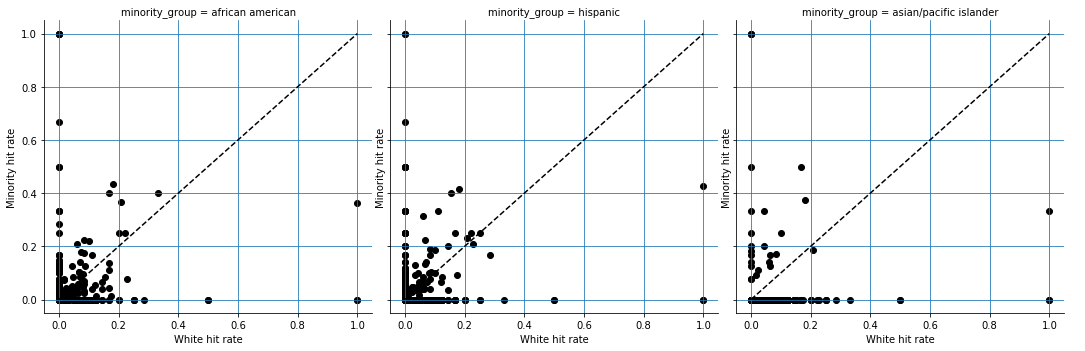

In [24]:
plotting.plot_hit_rates_comparison(hit_rates_comparison, 'minority_group', None)

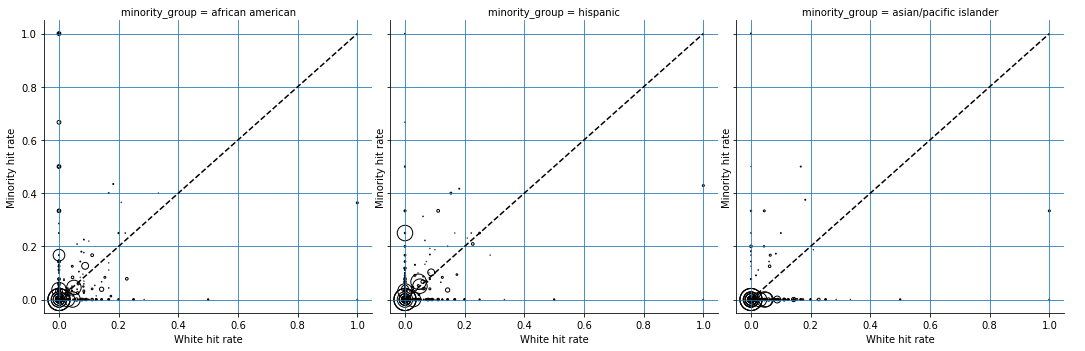

In [25]:
hit_rates_comparison_with_size = hit_rates_comparison.merge(calculations.calc_group_size(stops_2018, ['OfficerAbra'], False))
plotting.plot_hit_rates_comparison(hit_rates_comparison_with_size, 'minority_group', 'n', 5)

In [26]:
sacramento_lat = 38.5816
sacramento_long = -121.4944

sunset_times_2018 = calculations.calc_sunset_times(stops_2018, sacramento_lat, sacramento_long, 'UTC')
sunset_times_2018[(sunset_times_2018['sunset'] == sunset_times_2018['sunset'].min()) | (sunset_times_2018['sunset'] == sunset_times_2018['sunset'].max())]

,date,sunset,dusk,sunset_minute,dusk_minute
178,2018-06-29,03:34:26,04:06:12,214,246
198,2018-06-28,03:34:26,04:06:13,214,246
345,2018-12-07,00:44:37,01:14:09,44,74
356,2018-12-08,00:44:37,01:14:11,44,74


In [27]:
vod_stops = calculations.get_veil_of_darkness_observations(stops_2018, sunset_times_2018)

In [28]:
calculations.calc_vod_rate(vod_stops, '03:30', '03:45', 'african american', 'subject_race')

is_dark
0    0.400000
1    0.375969
Name: is_african american, dtype: float64

In [29]:
is_black = (vod_stops['subject_race'] == 'african american').astype(int)
X = vod_stops[['is_dark']].merge(dmatrix("cr(data,df = 6)", {"data": vod_stops['minute']}, return_type='dataframe'),
                                left_index = True, right_index = True)
# X = sm.add_constant(X)
# X
logit_model = sm.GLM(is_black, X, family=sm.families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           subject_race   No. Observations:                 3929
Model:                            GLM   Df Residuals:                     3922
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2602.1
Date:                Mon, 15 Apr 2019   Deviance:                       5204.3
Time:                        08:52:56   Pearson chi2:                 3.93e+03
No. Iterations:                     4   Covariance Type:             nonrobust
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
is_dark              -0.0779      0.080     -0.979      0.328      -0.234       0.078
Intercept            -0.3882   

In [30]:
accuracy_score(is_black.values, (logit_results.predict(X) > 0.5).astype(int).values)

0.622295749554594

In [31]:
X = vod_stops[['is_dark']].merge(dmatrix("cr(data,df = 6)", {"data": vod_stops['minute']}, return_type='dataframe'),
                                left_index = True, right_index = True)
X = X.merge(pd.get_dummies(vod_stops['OfficerAbra']), left_index = True, right_index = True)
logit_model = sm.GLM(is_black, X, family=sm.families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

/anaconda3/envs/general/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:879: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/anaconda3/envs/general/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/anaconda3/envs/general/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:879: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/anaconda3/envs/general/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


                 Generalized Linear Model Regression Results                  
Dep. Variable:           subject_race   No. Observations:                 3929
Model:                            GLM   Df Residuals:                     3651
Model Family:                Binomial   Df Model:                          277
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 15 Apr 2019   Deviance:                          nan
Time:                        08:54:11   Pearson chi2:                 7.26e+18
No. Iterations:                   100   Covariance Type:             nonrobust
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
is_dark           -6.905e+12    2.9e+06  -2.38e+06      0.000    -6.9e+12    -6.9e+12
Intercept         -7.285e+14   

/anaconda3/envs/general/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:932: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/anaconda3/envs/general/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:932: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/anaconda3/envs/general/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:932: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/anaconda3/envs/general/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:933: RuntimeWarning: divide by zero encountered in log
  n * np.log(1 - mu)) * var_weights
/anaconda3/envs/general/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:933: RuntimeWarning: invalid value encountered in add
  n * np.log(1 - mu)) * var_weights


In [32]:
is_hispanic = (vod_stops['subject_race'] == 'hispanic').astype(int)
X = vod_stops[['is_dark']].merge(dmatrix("cr(data,df = 6)", {"data": vod_stops['minute']}, return_type='dataframe'),
                                left_index = True, right_index = True)
# X = sm.add_constant(X)
# X
logit_model = sm.GLM(is_hispanic, X, family=sm.families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           subject_race   No. Observations:                 3929
Model:                            GLM   Df Residuals:                     3922
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2096.4
Date:                Mon, 15 Apr 2019   Deviance:                       4192.9
Time:                        08:54:30   Pearson chi2:                 3.93e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
is_dark              -0.0460      0.092     -0.503      0.615      -0.225       0.133
Intercept            -1.0548   